In [19]:
import os
import time
import pandas as pd
import torch
import optuna
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

Load the dataset

In [20]:
df = pd.read_csv('final_dataset.csv')

In [21]:
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [23]:
train_encodings = tokenizer.batch_encode_plus(X_train.tolist(),
                                              add_special_tokens=True,
                                              max_length=128,
                                              padding='max_length',
                                              truncation=True,
                                              return_attention_mask=True,
                                              return_tensors='pt')

In [24]:
test_encodings = tokenizer.batch_encode_plus(X_test.tolist(),
                                             add_special_tokens=True,
                                             max_length=128,
                                             padding='max_length',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_tensors='pt')

In [25]:
label_mapping = {'fake': 0, 'genuine': 1}

In [26]:
y_train_num = [label_mapping[label] for label in y_train]
y_test_num = [label_mapping[label] for label in y_test]

In [27]:
class YelpDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = {k: v.clone().detach() for k, v in encodings.items()}
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [28]:
train_dataset = YelpDataset(train_encodings, y_train_num)
test_dataset = YelpDataset(test_encodings, y_test_num)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [30]:
def save_checkpoint(model, optimizer, epoch, batch_idx, path='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

In [31]:
def load_checkpoint(model, optimizer, path='checkpoint.pth'):
    if os.path.isfile(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        batch_idx = checkpoint['batch_idx']
        return epoch, batch_idx
    else:
        return None, None

In [32]:
train_losses = []
train_accuracies = []

In [33]:
def train(model, device, loader, optimizer, start_epoch, start_batch_idx, criterion, patience=3):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    start_time = time.time()
    checkpoint_interval = 30 * 60  # 30 minutes in seconds
    best_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(start_epoch, 5):  # Adjust the range as needed
        epoch_loss = 0
        epoch_correct_predictions = 0
        epoch_total_predictions = 0
        for batch_idx, batch in enumerate(loader):
            if epoch == start_epoch and batch_idx < start_batch_idx:
                continue  # Skip batches already processed in the previous run
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            epoch_loss += loss.item()

            # Calculate training accuracy
            predictions = torch.argmax(outputs.logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            epoch_correct_predictions += (predictions == labels).sum().item()
            epoch_total_predictions += labels.size(0)

            # Check if 30 minutes have passed
            elapsed_time = time.time() - start_time
            if elapsed_time >= checkpoint_interval:
                print(f'Saving checkpoint at epoch {epoch}, batch {batch_idx}')
                save_checkpoint(model, optimizer, epoch, batch_idx)
                start_time = time.time()  # Reset the start time
        avg_epoch_loss = epoch_loss / len(loader)
        epoch_accuracy = epoch_correct_predictions / epoch_total_predictions
        print(f'Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
        train_losses.append(avg_epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Early stopping
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

In [34]:
def evaluate(model, device, loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

In [35]:
def plot_roc_curve(true_labels, predictions, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [36]:
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2, hidden_dropout_prob=dropout_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    avg_loss, accuracy = train(model, device, train_loader, optimizer, 0, 0, criterion)
    predictions, true_labels = evaluate(model, device, test_loader)
    test_accuracy = accuracy_score(y_test_num, predictions)
    
    return test_accuracy

In [37]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

[I 2024-07-14 22:20:40,555] A new study created in memory with name: no-name-70b3ad5d-d209-408b-91a6-a005b17b8ea9
C:\Users\Admin\AppData\Local\Temp\ipykernel_10980\2126660668.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10980\2126660668.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'cl

Epoch 1, Loss: 0.5418, Accuracy: 0.7852
Epoch 2, Loss: 0.5115, Accuracy: 0.7846
Epoch 3, Loss: 0.4587, Accuracy: 0.7878
Epoch 4, Loss: 0.4352, Accuracy: 0.7970
Saving checkpoint at epoch 4, batch 282
Epoch 5, Loss: 0.4221, Accuracy: 0.8065


[I 2024-07-14 22:57:02,348] Trial 0 finished with value: 0.8074261129816686 and parameters: {'learning_rate': 3.4630091639438107e-06, 'batch_size': 32, 'dropout_rate': 0.4985092210933384}. Best is trial 0 with value: 0.8074261129816686.
C:\Users\Admin\AppData\Local\Temp\ipykernel_10980\2126660668.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10980\2126660668.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at r

Epoch 1, Loss: 0.4178, Accuracy: 0.8130
Epoch 2, Loss: 0.3724, Accuracy: 0.8327
Epoch 3, Loss: 0.3596, Accuracy: 0.8387
Saving checkpoint at epoch 3, batch 2084
Epoch 4, Loss: 0.3520, Accuracy: 0.8422
Epoch 5, Loss: 0.3433, Accuracy: 0.8442


[I 2024-07-14 23:37:25,111] Trial 1 finished with value: 0.8513842124953236 and parameters: {'learning_rate': 4.83178322169162e-06, 'batch_size': 16, 'dropout_rate': 0.381546230750183}. Best is trial 1 with value: 0.8513842124953236.
C:\Users\Admin\AppData\Local\Temp\ipykernel_10980\2126660668.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10980\2126660668.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at robe

Epoch 1, Loss: 0.3987, Accuracy: 0.8194
Epoch 2, Loss: 0.3467, Accuracy: 0.8439
Epoch 3, Loss: 0.3356, Accuracy: 0.8498
Saving checkpoint at epoch 3, batch 2058
Epoch 4, Loss: 0.3267, Accuracy: 0.8544
Epoch 5, Loss: 0.3186, Accuracy: 0.8566


[I 2024-07-15 00:17:54,057] Trial 2 finished with value: 0.8543771043771043 and parameters: {'learning_rate': 1.4819058548456354e-06, 'batch_size': 16, 'dropout_rate': 0.22386921125972112}. Best is trial 2 with value: 0.8543771043771043.
C:\Users\Admin\AppData\Local\Temp\ipykernel_10980\2126660668.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10980\2126660668.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at 

Epoch 1, Loss: 0.5108, Accuracy: 0.7805
Epoch 2, Loss: 0.4111, Accuracy: 0.8119
Epoch 3, Loss: 0.3908, Accuracy: 0.8243
Epoch 4, Loss: 0.3846, Accuracy: 0.8273
Saving checkpoint at epoch 4, batch 201
Epoch 5, Loss: 0.3781, Accuracy: 0.8314


[I 2024-07-15 00:54:43,936] Trial 3 finished with value: 0.847268986157875 and parameters: {'learning_rate': 1.0589304921058389e-06, 'batch_size': 32, 'dropout_rate': 0.38657706758597676}. Best is trial 2 with value: 0.8543771043771043.
C:\Users\Admin\AppData\Local\Temp\ipykernel_10980\2126660668.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10980\2126660668.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at r

Epoch 1, Loss: 0.5277, Accuracy: 0.7864
Epoch 2, Loss: 0.5242, Accuracy: 0.7868
Epoch 3, Loss: 0.5236, Accuracy: 0.7867
Saving checkpoint at epoch 3, batch 1701
Epoch 4, Loss: 0.5223, Accuracy: 0.7868
Epoch 5, Loss: 0.5223, Accuracy: 0.7868


[I 2024-07-15 01:40:37,253] Trial 4 finished with value: 0.7759072203516648 and parameters: {'learning_rate': 2.7209549063094375e-05, 'batch_size': 8, 'dropout_rate': 0.245128059062437}. Best is trial 2 with value: 0.8543771043771043.


In [38]:
best_trial = study.best_trial
print(f'Best trial: Value: {best_trial.value}, Params: {best_trial.params}')

Best trial: Value: 0.8543771043771043, Params: {'learning_rate': 1.4819058548456354e-06, 'batch_size': 16, 'dropout_rate': 0.22386921125972112}


Use the best hyperparameters to train the final model

In [39]:
best_params = best_trial.params
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout_rate = best_params['dropout_rate']

In [40]:
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

In [41]:
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2, hidden_dropout_prob=best_dropout_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.22386921125972112, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [43]:
avg_loss, accuracy = train(model, device, train_loader, optimizer, 0, 0, criterion)

Epoch 1, Loss: 0.4016, Accuracy: 0.8199
Epoch 2, Loss: 0.3483, Accuracy: 0.8457
Epoch 3, Loss: 0.3379, Accuracy: 0.8487
Saving checkpoint at epoch 3, batch 2067
Epoch 4, Loss: 0.3286, Accuracy: 0.8516
Epoch 5, Loss: 0.3214, Accuracy: 0.8555


In [44]:
predictions, true_labels = evaluate(model, device, test_loader)
test_accuracy = accuracy_score(y_test_num, predictions)
print(f'Final Test Accuracy: {test_accuracy:.4f}')

Final Test Accuracy: 0.8550


In [45]:
def predict(model, tokenizer, text, device):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    return 'genuine' if predictions.item() == 1 else 'fake'

In [46]:
user_input = input("Enter text for prediction (or type 'exit' to quit): ")
prediction = predict(model, tokenizer, user_input, device)
print(f'Predicted class: {prediction}')

Predicted class: fake


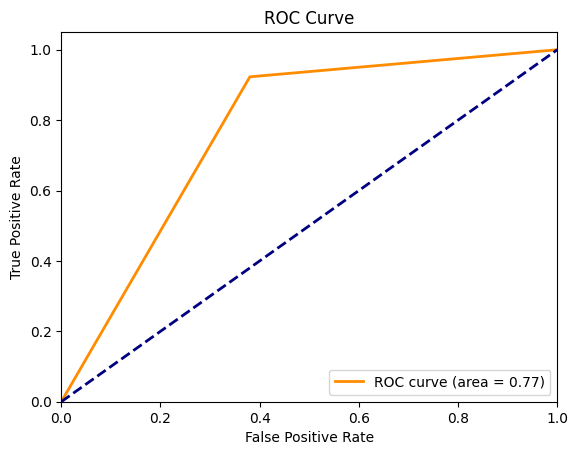

In [47]:
plot_roc_curve(y_test_num, predictions)

In [48]:
epochs = list(range(1, len(train_losses) + 1))

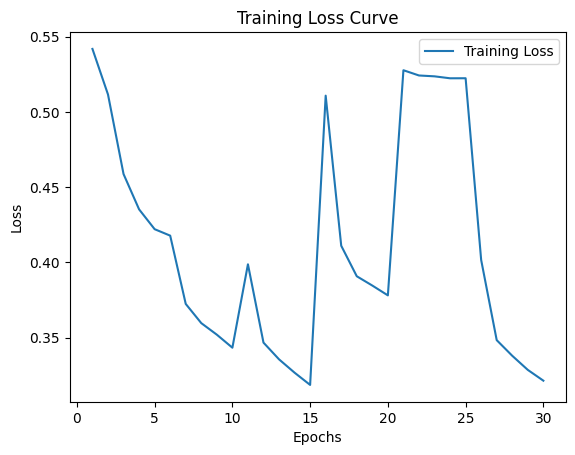

In [49]:
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

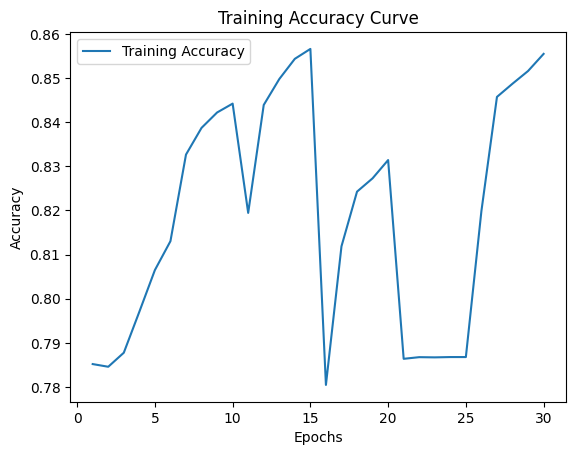

In [50]:
plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

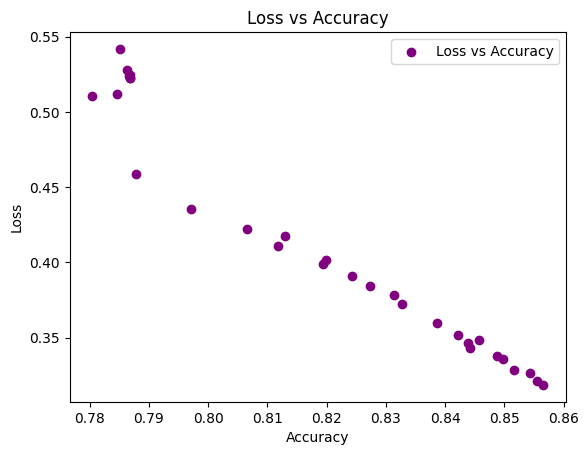

In [51]:
plt.figure()
plt.scatter(train_accuracies, train_losses, label='Loss vs Accuracy', color='purple')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.title('Loss vs Accuracy')
plt.legend()
plt.show()